# Toumetis Case Study - A Eaton - May 2020


---
**Summary:**

*This notebook contains a case study provided by Toumetis in May 2020. The raw data is explored and visualised, and is then cleaned and normalised. A set of sequences, with class labels corresponding to the operational mode at the last time step, is generated to create training and test sets. Re-sampling of the sequence data removes class imbalance, specifically the underepresentation of the asset failure modes. A model comprising two 1D convolutional layers and a long short term memory (LSTM) layer is trained on the re-sampled sequence data for 30 epochs.The model achieves an accuracy of >99% when evaluated on the test data. The majority of misclassifications are due to the model mistaking two specific modes for one another.*



**Contents:**

1. Introduction & problem outline
2. Exploratory analysis of raw data
3. Data preprocessing
4. Deep learning model
5. Conclusion & recommendations



# 1. Introduction & problem outline


---




<a id='intro'></a>
**The objective of this case study is to create a deep learning model that predicts the operational mode of industrial equipment using historical time series data.**
 
The problem description states that there are 36 industrial machines (assets) that have been fitted with sensors. The behaviour of the assets has been recorded over time and a domain expert has labelled each section with an operational mode type. The properties of the assets and sensors themselves are not described.

The goal of the model is to predict the operational mode of an asset based on the sensor time histories alone. The only other requirements for the model are that it should : 1) be built in Python, 2) be a deep neural network, and 3) be a classifer. There are no customer requirements relating to model performance (i.e. the minimum acceptable accuracy) or the computational budget. The raw data is provided in .csv format. This notebook has been written with a technical audience in mind.

**A number of initial assumptions are made:**
1. All 36 assets are the same equipment type, and are therefore comparable
2. The operational mode labels provided in the raw data are all correct
3. The model will be designed to receive an input time history of *n* steps and predict the operational mode at the last time step
3. A test accuracy of around ~99% is acceptable for this exercise


# 2. Exploratory analysis of raw data


---





The purpose of this section is to ingest the raw data and gain an overall understanding of the information. This comprises:

*   Confirming the information in the problem statement
*   Determining the total number of time steps in the data
*   Identifying any null/not-a-number (NaN) entries
*   Verifying the intervals of the time steps
*   Identifying any potential class imbalances
*   Visualising the time histories


**Data ingestion**


---



The raw data is loaded and the first 5 rows are printed. The data contains columns for time, asset ID, operational mode, and each of the three sensors. The columns are manually renamed before loading, as the first header is missing in the original data. Time values are in the format: "*year-month-date hour:min:sec*".

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

########## define user path - edit as required ##########
path = '/content/drive/My Drive/Colab Notebooks'

# load raw data and rename columns (first header is missing in .csv file)
df = pd.read_csv(path + '/data.csv', sep=",", header=1)
df.columns = ['time','id','mode','s1','s2','s3']
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,time,id,mode,s1,s2,s3
0,2016-01-01 00:05:00,33,a,5.012288,11.264028,0.953424
1,2016-01-01 00:10:00,33,a,4.903325,10.882658,-0.081722
2,2016-01-01 00:15:00,33,a,-0.612916,18.496431,3.023717
3,2016-01-01 00:20:00,33,a,-1.184970,12.108489,7.205164
4,2016-01-01 00:25:00,33,a,1.375655,-2.492524,-6.510526


**General properties of raw data**


---
The general properties of the raw data are printed: the overall data shape, the unique asset IDs, the unique operational modes, and max/min of the sensor readings. There are 1098198 rows, 36 unique IDs (as expected from the problem description), and there are 6 unique operational mode classes (with categorical labels: 'a', 'b', 'c', 'd', 'e', 'f'). All sensor readings are found to be within the approximate range [-20, 20].


In [2]:
# get general properties
ids = df['id'].unique()                   # all unique ids (count = 36)
modes = df['mode'].unique()               # all unique modes (count = 6)
s_max = df[['s1','s2','s3']].max(axis=0)  # max sensor values
s_min = df[['s1','s2','s3']].min(axis=0)  # min sensor values

# print general properties
print('--------------------------------------------------------------------------------------------------')
print('Overall data shape:', df.shape)
print('Uniques asset IDs:',ids)
print('Unique modes:',modes)
print('Max sensor values:',s_max[0],',',s_max[1],',',s_max[2])
print('Min sensor values:',s_min[0],',',s_min[1],',',s_min[2])
print('--------------------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------------------
Overall data shape: (1098198, 6)
Uniques asset IDs: [33 17 20 29 13 15  6 27 36 18 32 35 11 16  5 10 28 26 14 24 12 23  4 30
 34  8 31 21  3 22  1  9 25  2  7 19]
Unique modes: ['a' 'b' 'c' 'd' 'f' 'e']
Max sensor values: 19.95 , 20.04 , 19.61
Min sensor values: -19.61 , -19.61 , -19.8
--------------------------------------------------------------------------------------------------


The null values in the raw data are identified. There are six null values; five of these are found in sensor 1 for asset ID 33, and one is found in sensor 3 for asset 11.



In [3]:
# locate any null values
null_cols = df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)])

                       time  id mode   s1         s2        s3
99      2016-01-01 08:20:00  33    a  NaN   0.272407  2.642348
999     2016-01-04 11:20:00  33    b  NaN  13.593107 -3.023717
1000    2016-01-04 11:25:00  33    b  NaN   9.234595 -1.266692
1001    2016-01-04 11:30:00  33    b  NaN   1.757025 -2.029432
11001   2016-02-08 04:50:00  33    b  NaN   9.080000  1.879608
405426  2016-01-22 12:35:00  11    b  4.4   4.400000       NaN


**Confirming sample rate and comparing mode time step counts**


---


Visual inspection of the raw data indicates that the time step interval between each row (within each asset ID) is a constant 5 mins. However, it is important that the time step is verified for the whole data, as any instances where the time step is not consistent would necessitate re-sampling and interpolation. Additionally, to understand whether there is a potential class imbalance, it is useful to observe how many time steps are allocated to each of the unique operational modes. If any particular modes are under-represented, the data may need to re-sampled before the modelling.

The function below obtains a breakdown of the time steps and intervals for a given asset ID number:

In [0]:
def get_ID_time(ID):
  # obtain the time step breakdown for a given asset ID

  # get dataframe for ID 
  df_id = df.loc[df['id'] == ID]
  df_id = df_id.drop(['id','s1','s2','s3'], axis=1)
  n_t = df_id.shape[0] 

  # format dates as datetime object
  pd.to_datetime(df_id['time'], format='%Y%m%d %H:%M:%S.%f')
  df_id['timestamp'] = pd.to_datetime(df_id['time'], format='%Y%m%d %H:%M:%S.%f')
  
  # get total time delta
  T0 = df_id['timestamp'].iloc[0]
  T1 = df_id['timestamp'].iloc[-1]
  dT_id = (T1-T0) # total time delta

  # find unique time steps
  dt = df_id['timestamp'] - df_id['timestamp'].shift() # row-by-row deltas
  unique_dt = dt.unique()
  unique_dt = np.delete(unique_dt,0) # idx 0 is always 'NaT' and can be deleted

  df_id_breakdown = pd.DataFrame(columns=['id', 'mode','n_t', 'unique_dt'])

  # assemble for all operational modes
  for mode in df_id['mode'].unique():
    df_m = df_id.loc[df['mode'] == mode]
    n_t_m = df_m.shape[0]

    new_row = {'id':ID, 'mode': mode, 'n_t': n_t_m, 'unique_dt': float(unique_dt)} 
    df_id_breakdown = df_id_breakdown.append(new_row, ignore_index=True)
  
  return df_id_breakdown

Time step information for all asset IDs (i.e. the whole dataset) is now assembled, using the function above. The time step in the data is confirmed as 5 mins only (ignoring the deltas between each ID).

In [5]:
df_breakdown = pd.DataFrame(columns=['id', 'mode','n_t', 'unique_dt']) # used for heatmap below

for id in df['id'].unique():
  # collect mode breakdowns for all asset ids
  df_breakdown = df_breakdown.append(get_ID_time(id), ignore_index=True)

print('Time step breakdowns assembled for all IDs')
print('Unique time intervals in whole dataset:', df_breakdown['unique_dt'].unique()*1e-9/60,'minutes') # originally in nanoseconds

Time step breakdowns assembled for all IDs
Unique time intervals in whole dataset: [5.] minutes


A heatmap that compares the number of time steps for each mode, within each asset ID, can now be generated. Note that white space corresponds indicates 0.

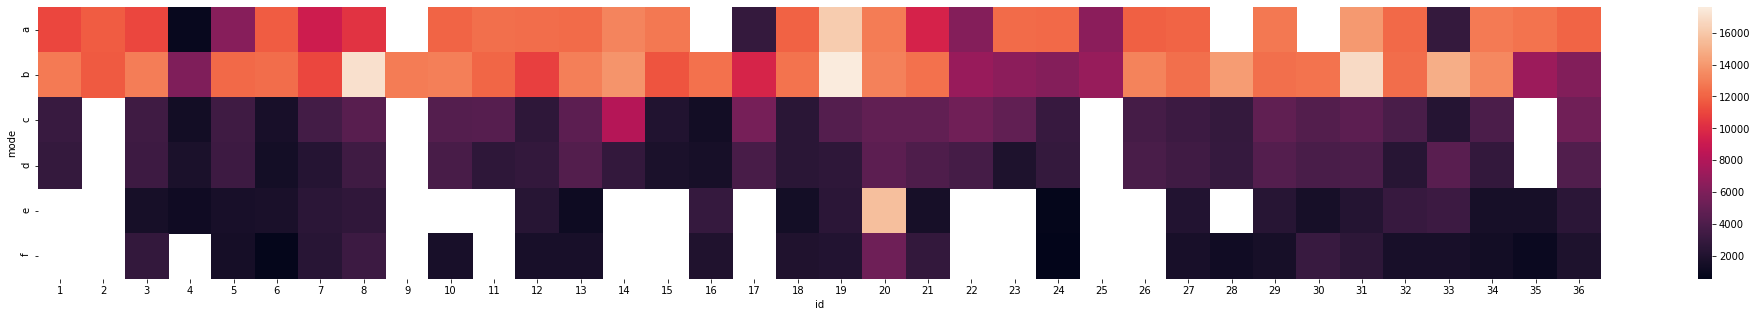

In [6]:
# plot heatmap
df_breakdown = df_breakdown.pivot("mode", "id", "n_t")
df_breakdown = df_breakdown.astype(np.float)
df_breakdown.fillna(0) 

fig, ax = plt.subplots(figsize=(35,5))        
sns.heatmap(df_breakdown, annot=False, ax=ax)

From the heatmap above, a number of observations are made.
*   The time histories for all asset IDs are dominanted by either mode 'a', 'b', or both, which suggests that these modes are the "standard operation" of the assets
*   17 of the 36 assets do not cover all operational modes (e.g. see ID 9, which is in mode 'b' for the entire duration) 
*   Modes 'e' and 'f' are missing from several assets; therefore, they are under-represented compared to other modes, and are likely failure modes of the equipment












**Visualisation of sensor time histories and sensor distributions of a given asset ID**

Since there are 36 different asset time histories (each comprising 3 sensor readings), it is convenient to create a function that plots the data for a single arbitrary ID; this can then be used to visualise the time history for a selected asset. Inspection of the plots for a range of IDs will provide a general overview of the asset time histories, and will reveal any characteristics that distinguish the operational modes.

The first function below plots the three sensor readings and mode, against time step, for a given ID. The operational mode is plotted on the secondary vertical axis. The second function plots the frequency distribution for each sensor reading.

In [0]:
def plot_ID_timehistory(ID):
  # plot time histories of sensor readings
  # extension - convert horizonal units to minutes

  # get dataframe for ID
  df_id = df.loc[df['id'] == ID]

  # create plot
  fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,7))

  axes[0].plot(df_id['s1'], color='grey')
  axb = axes[0].twinx()
  axb.plot(df_id['mode'],color='red')
  axb.yaxis.grid(True)
  axes[0].set(ylabel="s1")
  axes[0].set(title='Asset ID: ' + str(ID))

  axes[1].plot(df_id['s2'], color='grey')
  axb = axes[1].twinx()
  axb.plot(df_id['mode'],color='red')
  axb.yaxis.grid(True)
  axes[1].set(ylabel="s2")

  axes[2].plot(df_id['s3'], color='grey')
  axb = axes[2].twinx()
  axb.plot(df_id['mode'],color='red')
  axb.yaxis.grid(True)
  axes[2].set(ylabel="s3")
  
def plot_ID_sensor_hist(ID):
  # plot histogram of sensor readings
  # extension - split into the different modes
  
  # get dataframe for ID
  df_id = df.loc[df['id'] == ID]

  # create plot
  fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(17,3))

  b = 150
  df_id.hist(ax=axes[0],column='s1', bins=b)
  df_id.hist(ax=axes[1],column='s2', bins=b)
  df_id.hist(ax=axes[2],column='s3', bins=b)

The time histories and sensor distributions for a given set of asset IDs (e.g. 33 and 9) can now be plotted. The operational mode is given by the red line.

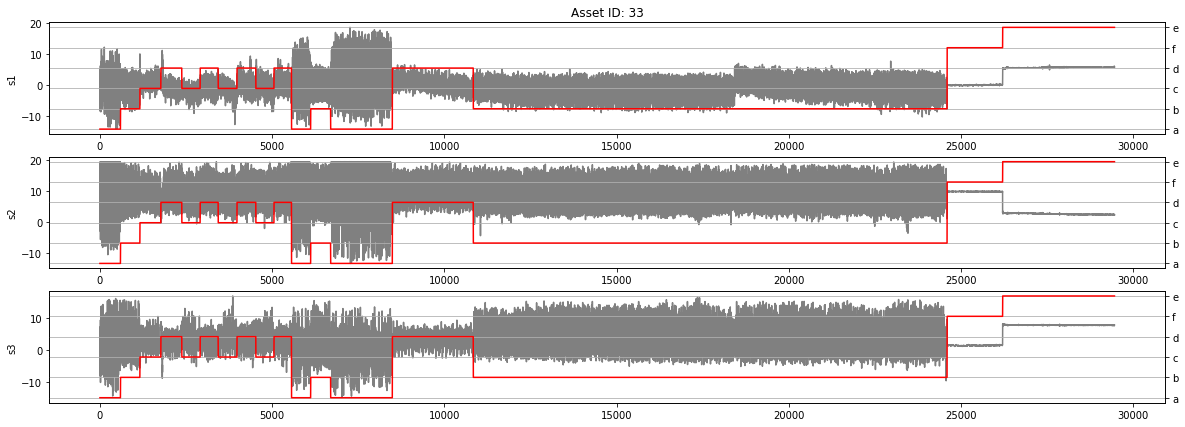

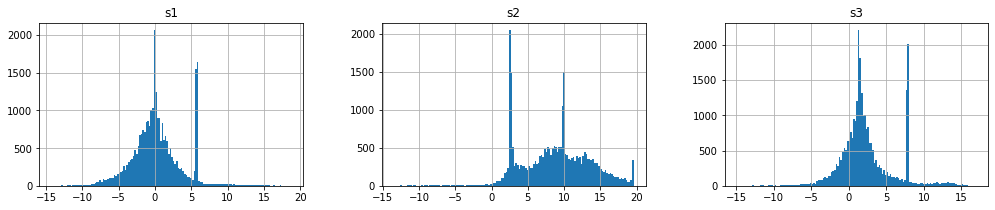

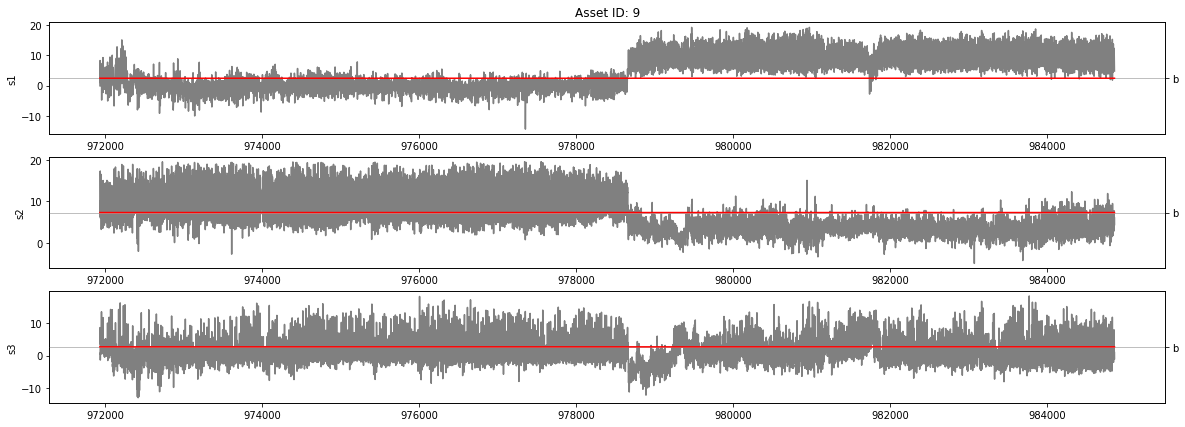

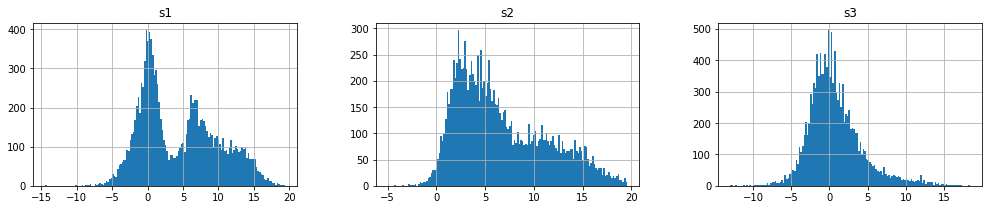

In [8]:
# plot the sensor time histories and histograms for selected IDs
for id_plt in [33, 9]:
  plot_ID_timehistory(id_plt)
  plot_ID_sensor_hist(id_plt)

The plots above show that the different operational modes correspond to different behaviours of the asset. 

*   Mode 'a' is typically characterised by large-amplitude oscillations
*   Modes 'c' and 'd' tend to alternate quickly and are rarely held for long
*   Modes 'e' and 'f' seemingly correspond to static behaviour
*   Sensor 1 often reaches saturation during mode 'a'
*   Sensor readings are broadly normally distributed, although for some IDs the distributions are bimodal (e.g. sensor 1 for ID 9). There are also spikes in some cases (typically one near 0, but not always)


**Data ingestion and exploration: key points**


---




*   The raw data contains time histories for 36 assets, and each time step is labelled as 1 of 6 operational modes
*   There are 6 null values; 5 of these occur within asset ID 33, sensor 1
*   The time interval between each row is a constant 5 mins (1/300 Hz sample rate)
*   There are potential class imbalances due to the under-representation of modes 'e' and 'f'
*   Charecteristics of the modes are indicated by the asset ID time histories; for example, mode 'a' typically comprises large-amplitude oscillations


# 3. Data preprocessing


---



The purpose of this section is to pre-process the raw data, given the observations made in Section 2, and to prepare the data into sequences that can be used to obtain training and test sets for the model. The preprocessing comprises:

*   Imputing values to populate NaN entries
*   Normalising the sensor reading values
*   Generating sequence data using a 'sliding window' method, so it is appropriate for derived train and test data






**Populate NaN values and normalise data**


---
To remove the null entries in the raw data, a linear interpolation is performed. The new data is checked and it is confirmed that there are no null values.


In [9]:
# use linear interpolation
df_int = df.interpolate(method='linear') # takes about 50s for me - there will be quicker way of doing this

# confirm null values are removed
null_cols = df_int.columns[df_int.isnull().any()]
print(df_int[df_int.isnull().any(axis=1)])

Empty DataFrame
Columns: [time, id, mode, s1, s2, s3]
Index: []


The new data is now normalised to the interval [0,1]. As there are no extreme sensor readings, normalisation is a valid transformation; moreover, as noted in Section 2, some sensor distributions appear bimodal for some IDs, so standardisation is not appropriate. Since the time step has been verified as constant throughout the data, the time column is no longer required and can be dropped.

In [10]:
from sklearn import preprocessing

# apply min/max scaling to create normalised data
min_max_scaler = preprocessing.MinMaxScaler()
cols_normalize = df_int.columns.difference(['time','id','mode']) # don't normalise time, id and mode columns
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df_int[cols_normalize]))
df_norm = df_int[df_int.columns.difference(cols_normalize)].join(df_norm)
df_norm = df_norm.drop(columns=['time'])
df_norm.head()

,id,mode,0,1,2
0,33,a,0.622404,0.778664,0.526603
1,33,a,0.619649,0.769046,0.500337
2,33,a,0.480209,0.961070,0.579135
3,33,a,0.465749,0.799962,0.685236
4,33,a,0.530477,0.431714,0.337211


**Generation of 'sliding window' function for retrieving sequence samples**


---


To train the model, the normalised data needs to be preprossessed into *sequence samples* with dimension **(sequence_length, n_sensors=3)**. Sequences will have a fixed length,  should only be derived from one asset ID (no mixing of e.g. 33 and 17), and the label for each sequence is taken as the operational mode at the *last* time step in the sequence. There is no padding, so the total number of permissable sequences from each ID is: *n_rows - sequence_length + 1*.

The function below applies the 'sliding window' approach to a given asset ID to generate sequences of a given length.

In [0]:
def get_sequences(ID, sequence_length, print_flag):
  # function to generate set of sequences for a given ID
  # target label (mode) for each sequence is taken from last time step 
  # output S is {n_seq x sequence_length x 3}

  df_id = df_norm.loc[df['id'] == ID] # get df for given id
  m = df_id['mode'].values # get list of mode classes
  df_id = df_id.drop(['mode','id'], axis=1) 
  X = df_id.values # get sensor values
 
  n = X.shape[0] # total number of available timesteps in id
  n_seq = n - sequence_length + 1 # total number of sequences available in id without padding
  # e.g. if there are 100 timesteps and the sequence length is 10, there are 91 sequences

  S = np.zeros(shape=(n_seq,sequence_length,3)) # pre-allocate total set output - 3 sensors hardcoded for now
  y = list() # pre-allocate labels output 

  for i in range(0,n_seq):  
    x0 = i
    x1 = i + sequence_length
    S[i,:,:] = X[x0:x1,:] # overall set of sequences
    y.append(m[x1-1])
  
  if print_flag: # for checking
    print('ID:',ID)
    print('total timesteps in ID:',n)
    print('shape of S:',S.shape)
    print('total labels for ID:', len(y))

  return S, y

To test the function above, a set of example sequences of length 64 are obtained from ID 33, and an arbitrary individual sequence (and label) is plotted.

ID: 33
total timesteps in ID: 29452
shape of S: (29389, 64, 3)
total labels for ID: 29389


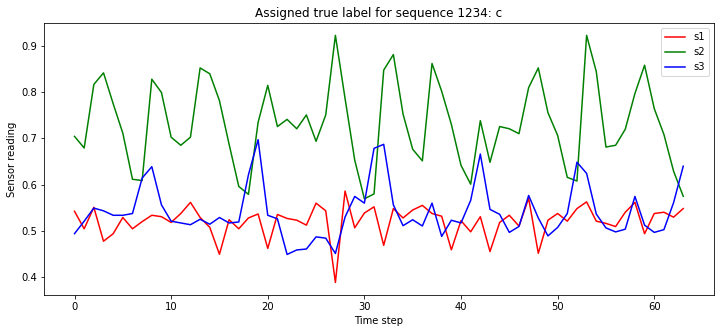

In [12]:
#### Example: for ID 33, generate all sequences of length 64, plot an arbitary sequence and show its assigned label 
S, y = get_sequences(33, 64, True) # S can be large (~30mb)
S_all = list()

def plot_seq(S,y,n):
  # plot a sequence given the sequence set, y and n

  fig = plt.figure(figsize=(12,5))

  ax1 = fig.add_subplot(1,1,1)
  ax1.plot(S[n,:,0], color='red')
  ax1.plot(S[n,:,1], color='green')
  ax1.plot(S[n,:,2], color='blue')
  plt.legend(['s1','s2','s3'])
  plt.xlabel('Time step')
  plt.ylabel('Sensor reading')
  title = plt.title('Assigned true label for sequence '  + str(n) + ': ' + y[n])

# plot an abitrary sequence and show the assigned label
plot_seq(S,y,1234)

del S
 

**Assembling all sequence data and labels**


---
The function above is now used to assemble the set of all the permitted sequences for all asset IDs. The set of sequences will be used to create the training data and test data in Section 4. The 'one-hot encoding' method is applied to categorical mode labels, because they are assumed to be a nominal data type.

A sequence length of 64 time steps is chosen to ensure that enough transient dynamics are visable to the model. It is found that short sequences (e.g. 16 time steps) degrade the model performance.

In [13]:
sequence_length = 64 # sequence length used in all training and test data

# prepare sequence set and labels
S_all = np.zeros(shape=(0,sequence_length,3)) 
y_all = list([])

# get all permitted sequences for all IDs
print('Getting permitted sequences for all asset IDs..')
for id in df['id'].unique():    
  S_id, y_id = get_sequences(id, sequence_length, False)
  S_all = np.concatenate((S_all, S_id), axis =0)
  y_all = y_all + y_id
print('Done.')
del S_id

# use one-hot encoding on the mode labels
y_all = pd.DataFrame(y_all)
y_all = pd.get_dummies(y_all)

Getting permitted sequences for all asset IDs..
Done.


The shape and memory allocation of the set of sequences is inspected.

In [14]:
print("All sequence data:",S_all.shape)
print("All labels:",y_all.shape)

import sys
print('Size of all sequence data:', str(round(sys.getsizeof(S_all)*9.537e-7,2)),'Mb')

All sequence data: (1095930, 64, 3)
All labels: (1095930, 6)
Size of all sequence data: 1605.41 Mb


**Data preprocessing: key points**

---

*  NaN values in the raw data are filled vie linear interpolation and all data is scaled to the interval [0,1] 
*  The normalised data is used to create a set of fixed-length sequences



# 4. Deep learning model


---

In this section, the sequence data used to build the predictive model. This involves:

*   Creating train and test sets
*   Defining the neural network model architecture
*   Training the model and evaluating training performance
*   Evaluating the model on the test data








**Split sequence data into training and test sets**


---

Recall from Section 2 that modes 'e' and 'f' are underepresented in the data, i.e. there is a class imbalance. The imbalance is confirmed by viewing the labels for all the sequence data: modes 'a' and 'b' make up 38.6% and 31.2% respectively, whereas 'e' and 'f' only make up 5.5% and 4.5%.


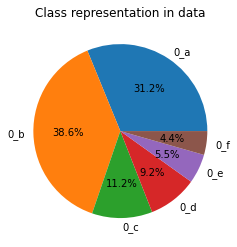

In [15]:
# show class representation of data
labels = y_all.columns
plt.pie(y_all.sum(axis=0),labels=labels,autopct='%1.1f%%',)
#print(y_all.sum(axis=0))
plt.title('Class representation in data')
plt.show()

To balance the classes, the sequence data is randomly re-sampled to ensure that each class has equal representation. The function below randomly picks *n* sequences from each operational mode and return their indexes. 

In [0]:
def sub_sample(y_all, n):
  # generate idx for equal samples for each mode
  samples_idx = np.zeros(shape=0)

  for m in y_all.columns:
    idx = y_all[y_all[m]==1].index
    np.random.seed(0) 
    sample_idx = idx[np.random.choice(idx.shape[0], n, replace=False)]
    samples_idx = np.concatenate((samples_idx, sample_idx), axis =0)
  
  samples_idx = samples_idx.astype(int)
  return samples_idx

The indexes are then used to create the sampled sequence data. The minimum class count in the data (which is 48394 for mode 'f') is is used as *n*. The size of the sampled data is checked, and is equal to 290364 (48394 x 6) as expected.

In [17]:
# get idx to use for sample
samples_idx = sub_sample(y_all,min(y_all.sum(axis=0)))

# create sampled set of sequences with balances class representation
S_sampled = S_all[samples_idx,:,:]
y_all_val = y_all.values
y_sampled = y_all_val[samples_idx,:]
y_sampled = pd.DataFrame(y_sampled)

print("Sequence data:",S_sampled.shape)
print("Labels:",y_sampled.shape)
print('Size of sequence data:', str(round(sys.getsizeof(S_sampled)*9.537e-7,2)),'Mb')

del S_all, y_all

Sequence data: (290364, 64, 3)
Labels: (290364, 6)
Size of sequence data: 425.35 Mb


The sampled sequence data is now divided into train and test sets using the standard 80:20 split. Viewing the total counts of each mode in both the train and test sets shows that there is neglible class imbalance in both sets.

Training data: (217773, 64, 3)
Test data: (72591, 64, 3)
Training labels: (217773, 6)
Test labels: (72591, 6)


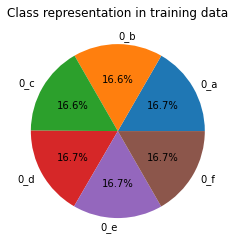

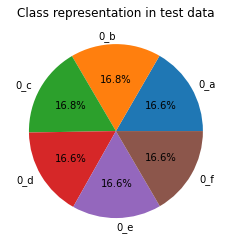

In [18]:
from sklearn.model_selection import train_test_split

# create test and train sets
X_train, X_test, y_train, y_test = train_test_split(S_sampled, y_sampled, random_state=1)

# print test and train set sizes
print("Training data:",X_train.shape)
print("Test data:",X_test.shape)
print("Training labels:",y_train.shape)
print("Test labels:",y_test.shape)

# class representation in training data
plt.pie(y_train.sum(axis=0),labels=labels,autopct='%1.1f%%')
plt.title('Class representation in training data')
plt.show()

# class representation in test data
plt.pie(y_test.sum(axis=0),labels=labels,autopct='%1.1f%%')
plt.title('Class representation in test data')
plt.show()

**Define model architecture**


---
The model archetective is now defined. It is found that a model comprising two 1D convolutional (Conv1D) layers and a songle long short term memory (LSTM) layer achieves >99% test accuracy within a reasonable timeframe. Conv1D networks are known to perform well in feature extraction in temporal classification tasks; however it is found that an LSTM layer is also required to learn the sequential dependancies and obtain high accuracy. The model is not found to overfit, so no dropout (i.e. regularisation) layers are used. Since this is a classification task, the cost function selected is *categorical cross-entropy*.


In [19]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping

# Conv1D-LSTM model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=8, padding='same', activation='relu', input_shape=(sequence_length,3)))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(LSTM(units=64,return_sequences=False)) # more units slows computation
model.add(Dense(units=6, activation='softmax')) # 6 units for the 6 classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Notes:
# 2-layer Conv1D-only model achieves 97.8% test accuracy after 30 epochs
# 1-layer LSTM-only model achieves 98.8% test accuracy after 30 epochs

print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 64, 256)           6400      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 64)            65600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 105,414
Trainable params: 105,414
Non-trainable params: 0
_________________________________________________________________
None


**Train model**


---
*The model takes ~50 mins to train for 30 epochs on Google Colab. Please see the 'Optional: load previously saved model' cell below if you want to load the pre-trained model.*

The model is now fit to the training data for a total of 30 epochs. A batch size of 128 is selected; large batch sizes are found to result in degraded performance (possibly due to the model getting trapped in local minima). The training data is automatically split further into training and validation sets while the model trains.

In [20]:
history = model.fit(X_train, y_train, epochs=30, batch_size=128, 
                    validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])

Train on 174218 samples, validate on 43555 samples
Epoch 1/30
174218/174218 [==============================] - 110s 634us/step - loss: 0.6127 - accuracy: 0.7358 - val_loss: 0.4015 - val_accuracy: 0.8366
Epoch 2/30
174218/174218 [==============================] - 109s 623us/step - loss: 0.3484 - accuracy: 0.8640 - val_loss: 0.3293 - val_accuracy: 0.8699
Epoch 3/30
174218/174218 [==============================] - 111s 639us/step - loss: 0.2368 - accuracy: 0.9154 - val_loss: 0.2228 - val_accuracy: 0.9170
Epoch 4/30
174218/174218 [==============================] - 108s 622us/step - loss: 0.1811 - accuracy: 0.9368 - val_loss: 0.2898 - val_accuracy: 0.8995
Epoch 5/30
174218/174218 [==============================] - 110s 632us/step - loss: 0.1506 - accuracy: 0.9493 - val_loss: 0.1436 - val_accuracy: 0.9530
Epoch 6/30
174218/174218 [==============================] - 108s 622us/step - loss: 0.1282 - accuracy: 0.9573 - val_loss: 0.1502 - val_accuracy: 0.9450
Epoch 7/30
174218/174218 [===========

In [21]:
# save training history to .csv file
hist_df = pd.DataFrame(history.history)
hist_csv_file = path + '/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

print("Saved training history")

# save model
model_json = model.to_json()
with open(path + '/model.json', "w") as json_file:
    json_file.write(model_json)
    
# save weights
model.save_weights(path + '/model_weights.h5')

print("Saved model and weights")

Saved training history
Saved model and weights


**Plot training and validation accuracy and loss**


---

The accuracy and loss of the model during the training epochs is plotted below. The plots show that the model performance on the training and validation sets are similar (although there is more variation on the validation set), and there are no clear signs of overfitting, which would be indicated if the training performance was significantly better than the validation performance. 

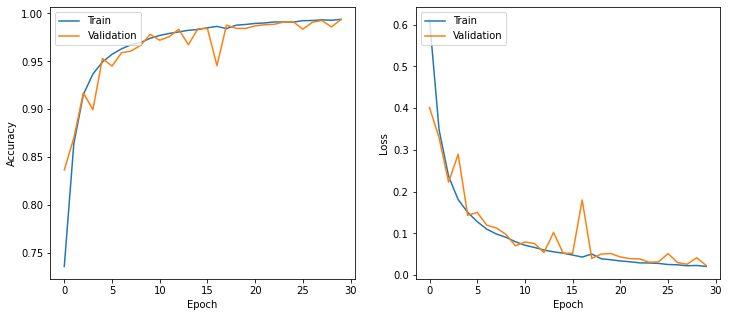

In [22]:
# plot training and validation metrics stored in history
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
plt.xlabel('Epoch')
ax1.plot(history.history['accuracy'], label ='Train')
ax1.plot(history.history['val_accuracy'], label ='Validation')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")

ax2 = fig.add_subplot(1,2,2)
plt.xlabel('Epoch')
ax2.plot(history.history['loss'], label ='Train')
ax2.plot(history.history['val_loss'], label ='Validation')
plt.ylabel('Loss')
plt.legend(loc="upper left")

fig.savefig(path + "/model_training.png")

***Optional: load previously saved model***


---

Use this option to performing test on the saved model.

In [0]:
# do you want to load a previous model?
load_model =  False

if load_model:
  from keras.models import model_from_json

  ## load saved model
  json_file = open(path + '/model_Conv1d_LSTM.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights(path + '/model_weights_Conv1d_LSTM.h5')
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  print("Loaded and compiled saved model")

**Evaluate model on test data**


---

The model is now evaluated on the test data. To make an overall assessment of the model performance, a confusion matrix is assembled. The accuracy of the model on the test data is then printed.

In [24]:
from sklearn.metrics import confusion_matrix

# predict labels for test set
print('Predicting labels of test data..')
y_test_pred = model.predict_classes(X_test, verbose=1)

# generate confusion matrix
y_test_true = y_test
y_test_true = y_test_true.idxmax(axis=1)
c_matrix = pd.DataFrame(confusion_matrix(y_test_pred, y_test_true.values))

# print test accuracy
test_accuracy = sum(np.diag(c_matrix.values))/c_matrix.to_numpy().sum()
print('--------------------------------------------------------------------------------------------------')
print('Test accuracy:', round(test_accuracy*100,3),'%')
print('--------------------------------------------------------------------------------------------------')

Predicting labels of test data..
72591/72591 [==============================] - 19s 257us/step
--------------------------------------------------------------------------------------------------
Test accuracy: 99.293 %
--------------------------------------------------------------------------------------------------


The confusion matrix is now plotted.

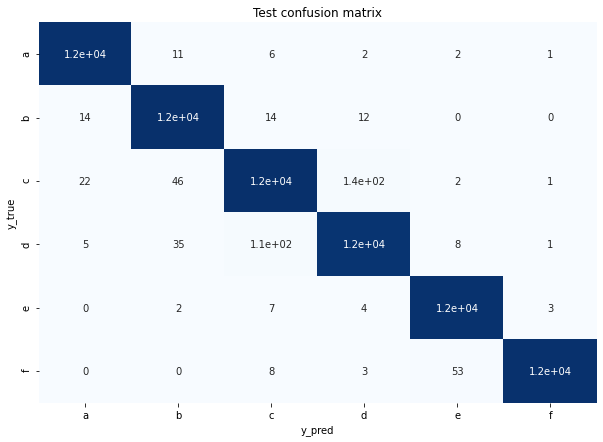

In [25]:
# plot confusion matrix
plt.subplots(figsize=(10,7))
ticks = ['a','b','c','d','e','f']
cm = sns.heatmap(c_matrix, annot=True, cmap='Blues', cbar=False, xticklabels=ticks, yticklabels=ticks)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Test confusion matrix')
plt.show()

fig = cm.get_figure()
fig.savefig(path + '/confusion_matrix.png')

The confusion matrix shows that the majority of the misclassifications occur when the model mistakes mode 'c' for mode 'd', and vice versa. An example of a misclassified sequence is plotted below; this sequence was assigned a (true) mode of 'c', but is predicted as 'd' by the model. The difficulty in differentiating modes 'c' and 'd' can partly be explained by the fact that, as observed in Section 2, these two modes tend to alternate within a relatively short time interval; thus, there is less steady data describing the characteristics of these modes.


Predicted mode for sequence 454: d


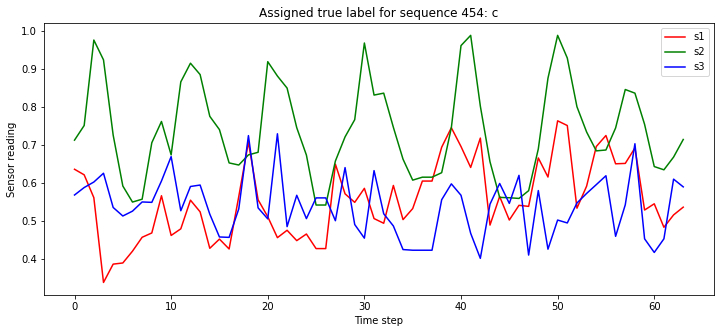

In [26]:
# assemble all predicted and true labels
df_y = pd.concat([pd.DataFrame({'y_pred': y_test_pred}), pd.DataFrame({'y_true': y_test_true.values})], axis=1)
df_y = df_y.replace({0:'a',1:'b',2:'c',3:'d',4:'e',5:'f'})

# make dataframe for all true 'c' but predicted 'd'
df_c = df_y.loc[df_y['y_true'] == 'c']
df_cd = df_c.loc[df_c['y_pred'] == 'd']

# plot an example sequence, the true label, and the predicted label
n = df_cd.index[0]
print('Predicted mode for sequence ' + str(n)+ ':' ,df_y['y_pred'].values[n])
plot_seq(X_test,df_y['y_true'].values,n)

**Deep learning model: key point**


---



*   Train and test sets are derived from the sequence data and ensure class balance is ensured
*   A Conv1D-LSTM model is compiled and trained for 30 epochs
*   A test accuracy of >99% is achieved
*   Misclassifications are mostly caused by modes 'c' and 'd'







# 6. Conclusion & recommendations


---











This exercise involved creating a deep learning model that predicts the operational mode of industrial assets using historical time series data. The model achieved ~99% accuracy when evaluated on the test data, after 30 epochs of training, using a sequence length of 64 time steps. A confusion matrix revealed that the majority of the misclassifications occurred when the model was predicting mode 'c' or 'd'; this is likely related to the intermittant existence of these modes in data.

The model is not optimal; further work and extensions are suggested below. Additionally, input from the customer is sought regarding the overall objectives of the model. 

**Improvements to the model:**

*   Further tuning of the model hyperparameters - this could be implemented programmatically by a grid search
* Implement a k-fold cross validation approach to more rigorously verify the model performance on the test data
*  Explore different model architectures - e.g. additional LSTM layers if longer sequences are desired
*  Investigate the use of spectral decomposition (i.e. Fourier transforms) and performing the analysis in the frequency domain

**Inputs sought from the customer:**

*   Computational requirements for the model and details as to how it will be deployed
*   Understanding the relative importance of the mode classification, and whether misclassifying 'c' and 'd' is significant
*   Understanding the physical properties of the assets and sensors, using domain experience, to better understand the modes (particularly 'c' and 'd')
*   Confirmation that 'e' and 'f' are failure modes of the assets - if so, creating a model that predicts remaining useful life (RUL) may be useful for the customer












